In [1]:
import collections
import multiprocessing
from typing import Optional, List
print('num cpus avail: ', multiprocessing.cpu_count())

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

num cpus avail:  128


In [2]:
# helpers
def normalize_frame(W, axis=0):
    """Normalize the columns of W to unit length"""
    W0 = W / np.linalg.norm(W, axis=axis, keepdims=True)
    return W0

def psd_sqrt(C):
    """Computes PSD square root"""
    d, V = np.linalg.eigh(C)
    D_sqrt = np.diag(np.sqrt(np.abs(d)))  # ensure positive eigenvals
    Csqrt = V @ D_sqrt @ V.T
    return Csqrt

def psd_square(C):
    """Computes PSD square"""
    C_squared = C.T @ C
    return C_squared

def compute_error(C, Ctarget, ord=2):
    return np.linalg.norm(C-Ctarget, ord=ord)

def get_g_opt(
    W,
    Css,
):
    """Compute optimal G."""
    N, K = W.shape
    # assert K == N * (N + 1) // 2, "W must have K = N(N+1)/2 columns."
    In = np.eye(N)
    gram_sq_inv = np.linalg.inv((W.T @ W) ** 2)
    Css_12 = psd_sqrt(Css)
    g_opt = gram_sq_inv @ np.diag(W.T @ (Css_12 - In) @ W)
    return g_opt

def smooth(x, window_size):
    return np.convolve(x, np.ones(window_size)/window_size, 'valid')

def rot2d(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def min_dist_2d(V, W):
    # enumerate all possible column axis flips and permutations for 2x2 matrix
    Q0 =[
        np.array([[1, 0], [0, 1]]),
        np.array([[1, 0], [0, -1]]),
        np.array([[-1, 0], [0, 1]]),
        np.array([[-1, 0], [0, -1]]),
        np.array([[0, 1], [1, 0]]),
        np.array([[0, 1], [-1, 0]]),
        np.array([[0, -1], [1, 0]]),
        np.array([[0, -1], [-1, 0]]),
    ]
    dists = [np.linalg.norm(V - W @ Q) for Q in Q0]
    return W @ Q0[np.argmin(dists)]

In [3]:
def context_adaptation_experiment(
        Css_list: List[np.ndarray],
        N: int,
        K: int,
        eta_w: float,
        eta_g: float,
        batch_size: int,
        n_context_samples: int,
        n_samples: int,
        g0: np.ndarray,
        W0: np.ndarray,
        alpha=1.,
        online=True,
        normalize_w=False,
        seed=None,
        error_ord=2,
        verbose: bool = True,
        ):
    rng = np.random.default_rng(seed)

    # make sources
    Css12_list = [psd_sqrt(Css) for Css in Css_list]
    n_contexts = len(Css_list)

    N, K = W0.shape

    In = np.eye(N)

    # Wrn = normalize_frame(In + .5*rng.standard_normal((N,N)))
    # Wnr = Wrn.T
    # Wnr = normalize_frame(In + .5*rng.standard_normal((N,N)))

    Wrn = np.maximum(In + .2*rng.standard_normal((N,N)), 0)
    Wnr = np.maximum(In + .2*rng.standard_normal((N,N)), 0)


    results = collections.defaultdict(list)

    T = n_contexts if n_context_samples == 0 else n_context_samples
    iterator = tqdm(range(T)) if verbose else range(T)
    g = g0.copy()
    m = np.zeros(K)
    # prepend and append the same 10 random contexts for plotting later
    pre_post = rng.integers(0, n_contexts, (10))
    contexts = np.concatenate([pre_post, rng.integers(0, n_contexts, (T-20, ) ), pre_post])
    for t in iterator:
        ctx = contexts[t]
        Css, Css12 = Css_list[ctx],  Css12_list[ctx]

        for _ in range(n_samples):

            if online:
                # draw sample and compute primary neuron steady-state
                s = Css12 @ rng.standard_normal((N, batch_size))  # sample data
                WGWT = (Wnr * g[None, :]) @ Wrn  # more efficient way of doing W @ np.diag(g) @ W.T
                M = np.linalg.solve(alpha*In + WGWT, In)  # more stable than inv
                r =  M @ s  # primary neuron steady-state

                # compute interneuron input/output and update g
                z = Wrn @ r  # interneuron steady-state input
                n = g[:, None] * z   # interneuron steady-state output
                dg = z**2 - np.ones(K)
                g = np.maximum(g + eta_g * np.mean(dg, -1), 0)
                dm = np.diag(Wrn@Wnr - In)
                m = np.maximum(m + 5 * eta_g * dm, 0)

                # update W
                rnT = r @ n.T / batch_size
                dWnr = rnT - Wnr * (g[None, :] + m)
                # dWnr = r @ z.T / batch_size - Wnr
                Wnr = np.maximum(Wnr + eta_w * dWnr, 0)
                Wnr = normalize_frame(Wnr)
                dWrn = dWnr.T
                Wrn = np.maximum(Wrn + eta_w * dWrn, 0)
                # Wrn = normalize_frame(Wrn.T).T
                Crr = M @ Css @ M.T

            results['g'].append(g)
            results['symmetry'].append(np.linalg.norm(Wrn-Wnr.T))
            results['weights'].append(np.linalg.norm(dm))
            results['error'].append(compute_error(Crr, In, error_ord))

    results.update({
        'W0': W0,
        'Wrn' : Wrn,
        'Wnr': Wnr,
        'N': N,
        'K': K,
        'eta_w': eta_w,
        'n_samples': n_samples,
        'g0': g0,
        'W0': W0,
        'seed': seed,
    })
    return results

def make_contexts(
    N: int,
    L: int,
    n_unique_contexts: int,
    min_lmbda: float = 0.,
    max_lmbda: float = 10.,
    rng: Optional[np.random.Generator]=None,
    ):
    if rng is None:
        rng = np.random.default_rng()

    V = rng.uniform(0,1,(N,L))

    V = normalize_frame(V)

    lmbdas = []
    while len(lmbdas) < n_unique_contexts:
        lmbda = rng.uniform(min_lmbda, max_lmbda, size=(L,))
        sparse_mask = rng.uniform(0., 1, size=(L,)) < 0.5   # sparsity mask
        lmbda = lmbda * sparse_mask

        if sum(lmbda) > 0:  # don't append if all zeros
            lmbdas.append(lmbda)

    Sigmas = [np.eye(N) + (V * lmbda[None,:]) @ V.T for lmbda in lmbdas]
    Css_list = [S.T@S for S in Sigmas]

    return V, Css_list

seed = 420
# seed = 42067
rng = np.random.default_rng(seed)
N = 2
L = 2
K = 2

n_unique_contexts = 64
min_lmbda, max_lmbda = 0., 4.
V0, Css_list = make_contexts(N, L, n_unique_contexts, min_lmbda, max_lmbda, rng)

alpha = 1.
eta_w = 1E-5
eta_g = 2E-2  # works with 1E-2
batch_size = 1  # batched stochastic gradient steps
n_context_samples = 1024  # number of contexts seen
n_samples = 1024 # number of samples per context
error_ord = 2  # ||Crr - In||_{error_ord}  (matrix norm)
verbose = True
online = True
normalize_w = False  # normalize W after each update

W0 = normalize_frame(rng.uniform(0,1,(N,N)))

# optimal g for each context in Css_list
g_opts = np.array([get_g_opt(W0, Css) for Css in Css_list])
g0 = np.median(g_opts, axis=0)  # init g to median of all optimal g's

results = context_adaptation_experiment(
    Css_list,
    N,
    K,
    eta_w if online else 1E-2,  # OVERRIDE eta_w if offline (can be very fast)
    eta_g,
    batch_size,
    n_context_samples,
    n_samples if online else 32,  # OVERRIDE n_samples if offline
    g0,
    W0,
    alpha,
    online,
    normalize_w,
    seed,
    error_ord,
    verbose,
)

100%|███████████████████████████████████████████████████████████████████| 1024/1024 [02:45<00:00,  6.18it/s]


In [4]:
results['Wrn'], results['Wnr'].T

(array([[0.93492949, 0.31240243],
        [0.63999176, 0.74788329]]),
 array([[0.93907698, 0.34370688],
        [0.63297347, 0.77417348]]))

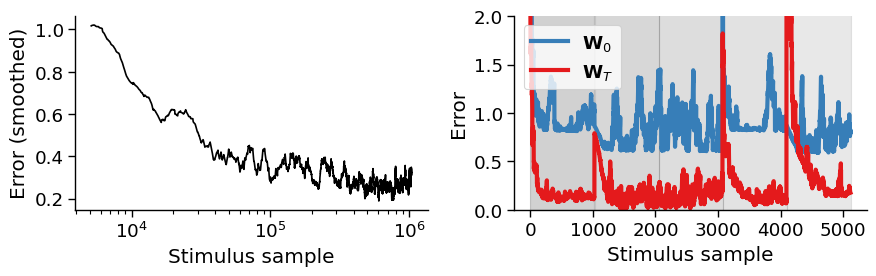

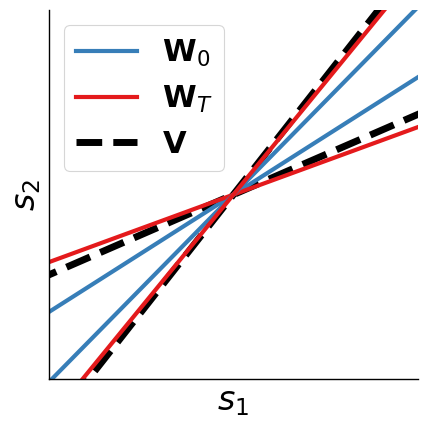

In [9]:
def plot_results(results, dpi):
    # plot error over time

    x = np.linspace(1, n_context_samples+1, len(results['error']))
    n_contexts_to_plot = 10
    T = n_samples*n_contexts_to_plot

    # plot all error
    error = results['error']

    T_smooth = 10*n_samples
    # smooth = lambda x, T: np.array(x)
    error_smooth = smooth(error, T_smooth)
    xx = np.arange(len(error))
    x_smooth  = smooth(xx, T_smooth)

    with sns.plotting_context('paper', font_scale=1.5):
        fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=dpi)
        ax[0].plot(x_smooth, error_smooth, 'k')
        lw = 3

        # plot error at early and late time chunks
        t0 = n_samples
        error = np.array(results['error'])
        error_early = error[5*t0:10*t0]
        error_late = error[-5*t0:]
        cols = sns.color_palette('Set1', 2)
        ax[1].plot(range(len(error_early)), error_early, '-' , markersize=5, color=cols[1], label=r'${\bf W}_0$', lw=lw)
        ax[1].plot(range(len(error_late)), error_late, '-', markersize=5, color=cols[0], label=r'${\bf W}_T$', lw=lw)

        cols = sns.color_palette('gray', 8)[:5]
        from matplotlib.patches import Rectangle

        # plot rectangle patches from (0, 0) to (n_samples, 10)
        # do 5 times in steps of n_samples
        for i in range(5):
            patch = Rectangle((i*t0 + i, 0), t0, 10, color=cols[i], alpha=0.2)
            ax[1].add_patch(patch)

        yscale ='linear'
        ax[0].set(yscale=yscale, xscale='log', xlabel='Stimulus sample', ylabel='Error (smoothed)')
        ax[1].set(yscale=yscale, xlabel='Stimulus sample', ylabel='Error', ylim=(0, 2.))
        ax[1].legend()

        sns.despine()
        fig.tight_layout()

    with sns.plotting_context('paper', font_scale=2.5):
        # compare W and V
        W0 = results['W0']
        W = results['Wnr']
        N, K = W.shape
        g = np.mean(results['g'][-1:],0)
        cols = sns.color_palette('Set1', 2)
        if N == 2:
            fig, ax = plt.subplots(1, 1, dpi=dpi)
            # plot basis vectors
            xrange = np.linspace(-2, 2, 100)
            WT = min_dist_2d(normalize_frame(V0), normalize_frame(W))
            rng = np.random.default_rng(42)
            xrange = np.linspace(-12, 12, 10)
            for i in range(2):

                v0 = V0[:, i]
                w0 = W0[:, i]
                w = W[:, i]
                ax.plot(xrange, w0[1]/w0[0] * xrange, color=cols[1], lw=3, label=r'${\bf W}_0$' if i == 0 else None)
                ax.plot(xrange, w[1]/w[0] * xrange, color=cols[0], lw=3, label=r'${\bf W}_T$' if i == 0 else None)
                ax.plot(xrange, v0[1]/v0[0] * xrange, 'k--', lw=5, zorder=-1, label=r'${\bf V}$' if i == 0 else None)

            ax.axis('square')
            MAX = .5
            ax.set(xlim=(-MAX, MAX), ylim=(-MAX, MAX), xticks=[], yticks=[], xlabel=r'$s_1$', ylabel=r'$s_2$')
            ax.legend(loc='upper left')
            sns.despine()

plot_results(results, dpi=None)

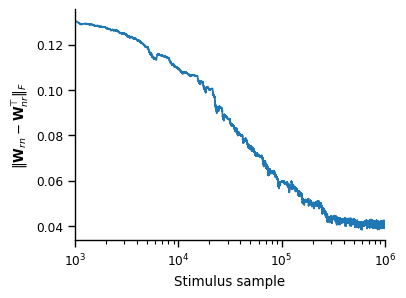

In [10]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=None)
    ax.semilogx(results['symmetry'])
    ax.set(xlim=([1e3,1e6]), ylabel=r'$\Vert {\bf W}_{r n} - {\bf W}_{n r}^\top\Vert_F$', xlabel='Stimulus sample')

sns.despine()